In [1]:
# reload custom package

%load_ext autoreload

%autoreload

import importlib
import ab_testing_kit
importlib.reload(ab_testing_kit)

<module 'ab_testing_kit' (<_frozen_importlib_external._NamespaceLoader object at 0x00000270FFA2A710>)>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from typing import List

# import custom package
from ab_testing_kit.exploration.data_exploration import explore_cardinality, explore_distribution
from ab_testing_kit.exploration.data_exploration import bivariate_date_num, correlation

pd.pandas.set_option('display.max_rows',None)
pd.pandas.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth', None)


from sklearn import set_config
set_config(transform_output = 'pandas')

import warnings
warnings.simplefilter(action="ignore")

# Import Data

In [3]:
FILE_PATH = "C:/Users/Oamen/OneDrive/Documents/DATA PROJECTS/AB_Testing_Kit/Datasets/marketing_campaign_tracking_events_large.csv"

In [4]:
df = pd.read_csv(FILE_PATH)
df['user_id'] = df['user_id'].astype(object)

df[:4]

,user_id,timestamp,event_type,ad_id,revenue
0,15796,2024-07-09 07:29:59,impression,118,13.94
1,861,2024-06-15 03:00:15,impression,129,12.43
2,76821,2024-07-20 04:09:32,impression,192,11.11
3,54887,2024-06-29 18:18:39,click,132,4.94


# Explore Data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287196 entries, 0 to 287195
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     287196 non-null  object 
 1   timestamp   287196 non-null  object 
 2   event_type  287196 non-null  object 
 3   ad_id       287196 non-null  int64  
 4   revenue     287196 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 11.0+ MB


## Check for duplicates and null values

In [6]:
f'There are {len(df[df.duplicated()])} duplicates in the data'

'There are 10715 duplicates in the data'

In [7]:
f"There are {len(df[df.duplicated(subset = 'user_id')])} duplicate user events"

'There are 213676 duplicate user events'

In [8]:
df.isnull().mean()

user_id       0.0
timestamp     0.0
event_type    0.0
ad_id         0.0
revenue       0.0
dtype: float64

## Check for whitespaces in rows and columns

In [9]:
# in column names
[column for column in df.columns if ' ' in column]

[]

In [10]:
# in rows
{column: f"{len(df[df[column] == ' '])} whitespace rows" for column in df.columns}

{'user_id': '0 whitespace rows',
 'timestamp': '0 whitespace rows',
 'event_type': '0 whitespace rows',
 'ad_id': '0 whitespace rows',
 'revenue': '0 whitespace rows'}

## Initial data cleaning(If needed)
- Remove whitespaces
- Remove duplicates
- Convert date column
- Fill null values

In [11]:
df = df.drop_duplicates()

In [12]:
df.columns = [column.lstrip().rstrip().replace(' ', '_') for column in df.columns]

df.columns

Index(['user_id', 'timestamp', 'event_type', 'ad_id', 'revenue'], dtype='object')

In [13]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [14]:
df.dropna(inplace = True)

## Univariate analysis and cardinality of categorical variables

In [15]:
categorical_columns = [column for column in df.columns if str(df[column].dtype) in ['object', 'bool'] and column!='timestamp']

numerical_columns = [column for column in df.columns if str(df[column].dtype) in ['int64', 'float64']]

date_columns = [column for column in df.columns if column not in categorical_columns and column not in numerical_columns]

user_id
Number of unique values in user_id: 73520
_________________________________________________________________________________
event_type
Number of unique values in event_type: 2
Unique values in event_type: ['impression', 'click']
Frequency of values in event_type: impression    0.785341
click         0.214659
Name: event_type, dtype: float64
_________________________________________________________________________________


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

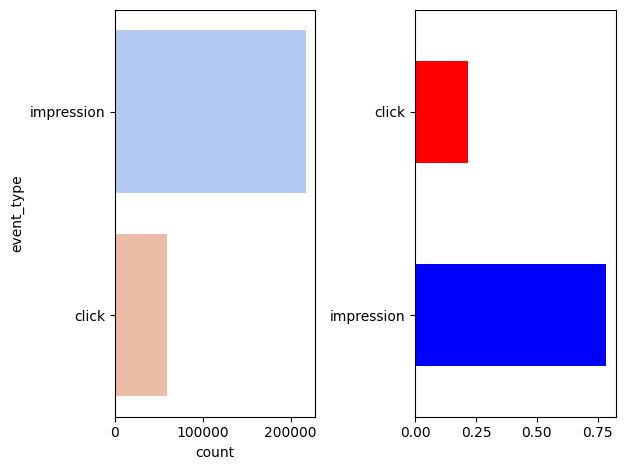

In [16]:
explore_cardinality(df,categorical_columns )

## Univariate analysis and distribution of numerical variables

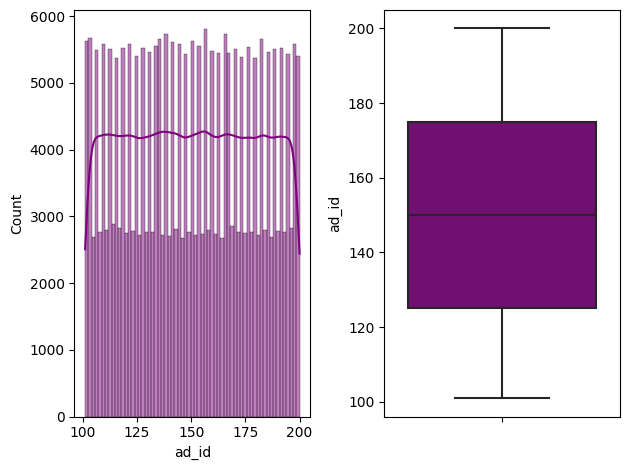

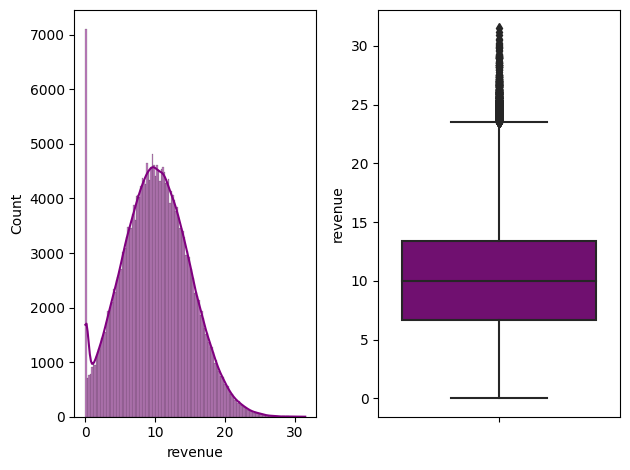

In [17]:
explore_distribution(df, numerical_columns)

## Bivariate analysis

### Date vs Numerical

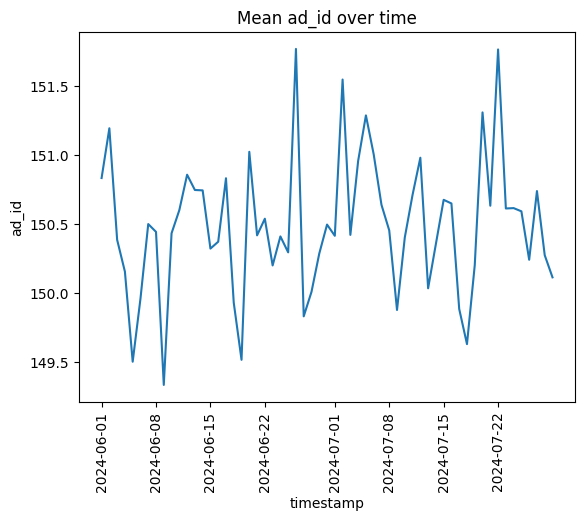

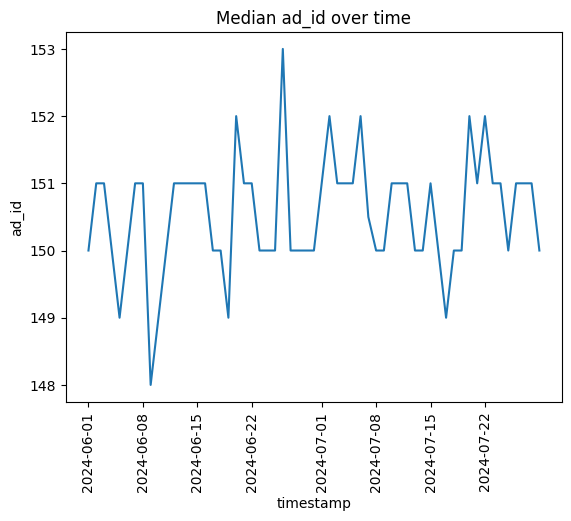

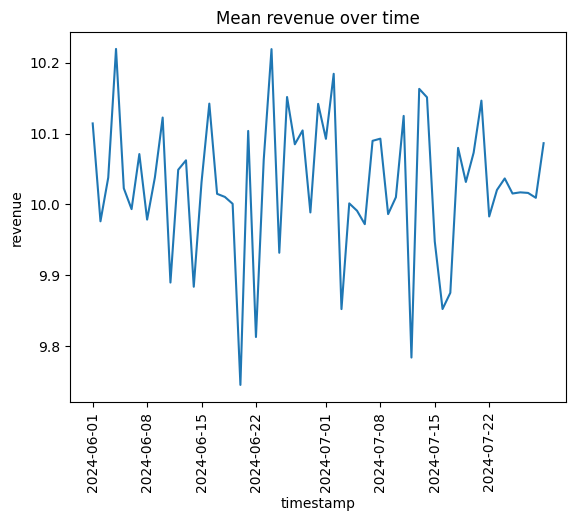

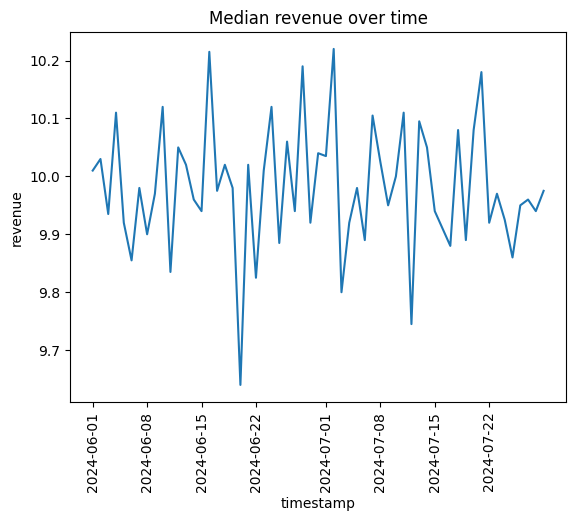

In [18]:
bivariate_date_num(df, time_type = 'd', date_columns = date_columns, numerical_columns = numerical_columns)

## Correlation

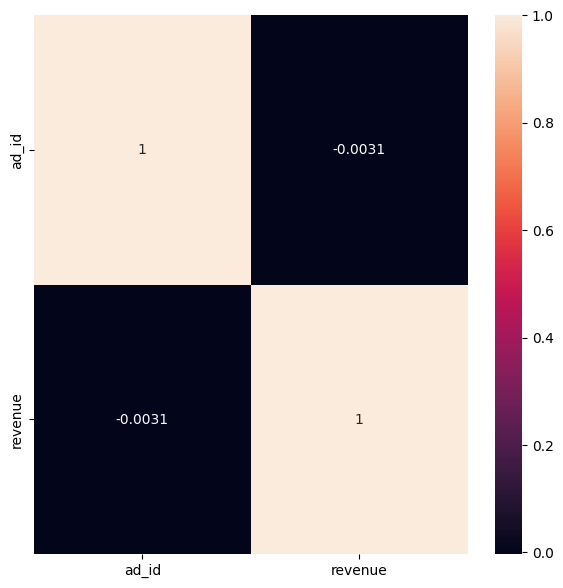

In [19]:
correlation(df)

# Aggregation

- Get the ad click events
- Get the average daily ctr per user
- Remove users with a ctr of 1
- Get the average revenue generated per user
- Get the daily users

In [20]:
# make a copy
df2 = df.copy()

# extract date
date = df2['timestamp'].dt.date

# insert into df
df2.insert(2, 'date', date)


df2 = df2.sort_values(by = ['user_id', 'date','event_type'])

In [21]:
# set click to 1, else 0
df2['ctr'] = np.where(df2['event_type'].str.lower() == 'click', 1, 0)

In [22]:
# Ensure revenue is zero when there is no activity
df2['revenue'] = np.where(df2['ctr'] == 0, 0, df2['revenue'])

## Average daily ctr and revenue per user

In [23]:
df3 = df2.groupby(['user_id','date'], as_index = False).agg({'ctr':'mean',
                                                            'revenue':'mean'})

## Extract users with a ctr below 1

In [24]:
max_ctr = df3.groupby('user_id', as_index = False)['ctr'].max()

users_ctr = dict(zip(max_ctr['user_id'], max_ctr['ctr']))

valid_users = [user for user, ctr in users_ctr.items() if ctr<1]

In [25]:
# filter dataset to users with an average ctr below 1

df3 = df3[df3['user_id'].isin(valid_users)]

## Daily Users

In [26]:
dau = df3.groupby('date',as_index = False)['user_id'].count()
dau = dau.rename(columns= {'user_id':'daily_users_num'})

merged = pd.merge(df3, dau, how = 'left', on = 'date')

In [27]:
merged['ctr'].value_counts()

0.000000    99213
0.500000     1264
0.333333       56
0.666667        7
0.250000        1
Name: ctr, dtype: int64

In [28]:
# save data

SAVE_PATH = "C:/Users/Oamen/OneDrive/Documents/DATA PROJECTS/AB_Testing_Kit/Datasets/marketing_campaign_aggregated.csv"
merged.to_csv(SAVE_PATH, index = False)